In [29]:
import pandas as pd
import numpy as np
from matplotlib import pyplot
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model

import keras
from tensorflow.keras.layers import Activation
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dense, Input, Dropout, Flatten, BatchNormalization, LSTM
from tensorflow.keras.layers import concatenate
from keras.utils import to_categorical
from tensorflow.keras import optimizers
from sklearn.metrics import confusion_matrix, classification_report

import seaborn as sns

In [2]:
# load a single file as a numpy array
def load_file(filepath):
    dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
    return dataframe.values
 
# load a list of files and return as a 3d numpy array
def load_group(filenames, prefix=''):
	loaded = list()
	for name in filenames:
		data = load_file(prefix + name)
		loaded.append(data)
	# stack group so that features are the 3rd dimension
	loaded = np.dstack(loaded)
	return loaded
 
# load a dataset group, such as train or test
def load_dataset_group(group, prefix=''):
	filepath = prefix + group + '/Inertial Signals/'
	# load all 9 files as a single array
	filenames = list()
	# total acceleration
	filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
	# body acceleration
	filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
	# body gyroscope
	filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
	# load input data
	X = load_group(filenames, filepath)
	# load class output
	y = load_file(prefix + group + '/y_'+group+'.txt')
	return X, y

# load the dataset, returns train and test X and y elements
def load_dataset(prefix=''):
    # load all train
    trainX, trainy = load_dataset_group('train', prefix + './data/UCI_HAR_Dataset/')
    # load all test
    testX, testy = load_dataset_group('test', prefix + './data/UCI_HAR_Dataset/')
    # zero-offset class values
    trainy = trainy - 1
    testy = testy - 1
    # one hot encode y
    trainy = to_categorical(trainy)
    testy = to_categorical(testy)
    print("trainX shape: ",trainX.shape)
    print("trainy shape: ", trainy.shape)
    print("testX shape: ", testX.shape)
    print("testy shape: ", testy.shape)
    return trainX, trainy, testX, testy


For training data we have 7352 different samples, where one sample is one window of the time series data, each window has 128 time steps, and a time step has nine variables or features.

Similarly for testing data we have 2947 different samples. 

In [3]:
trainX, trainy, testX, testy = load_dataset()

trainX shape:  (7352, 128, 9)
trainy shape:  (7352, 6)
testX shape:  (2947, 128, 9)
testy shape:  (2947, 6)


## Explore the data




In this dataset we have the following 9 features:


1.   Total Acceleration x
2.   Total Acceleration y
3.   Total Acceleration z
4.   Body Acceleration x
5.   Body Acceleration y
6.   Body Acceleration z
7.   Body Gyroscope x
8.   Body Gyroscope y
9.   Body Gyroscope z


In [10]:
# Helper function to plot distribution of the features
def plot_distributions(trainX):
	# remove overlap
	cut = int(trainX.shape[1] / 2)
	longX = trainX[:, -cut:, :]
	# flatten windows
	longX = longX.reshape((longX.shape[0] * longX.shape[1], longX.shape[2]))
	print(longX.shape)
	pyplot.figure()
	xaxis = None
	for i in range(longX.shape[1]):
		ax = pyplot.subplot(longX.shape[1], 1, i+1, sharex=xaxis)
		ax.set_xlim(-1, 1)
		if i == 0:
			xaxis = ax
		pyplot.hist(longX[:, i], bins=100)
	pyplot.show()

(470528, 9)


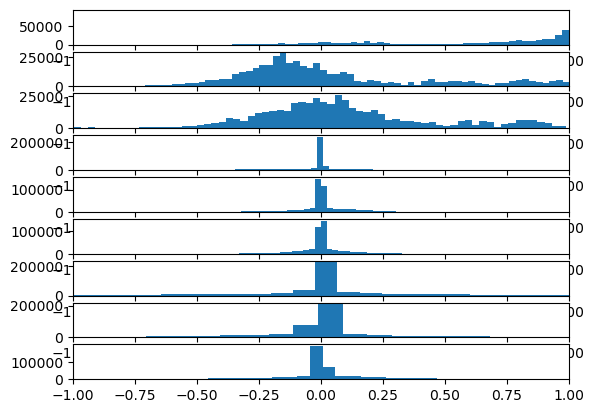

In [11]:
# plot distributions
plot_distributions(trainX)

We can see that all variables except "Total Acceleration x" behave like normal distributions. 

## Building the models

In this workshop, we will develop 2 deep learning models and evaluate the classification accuracy.



1.   LSTM model
2.   CNN model



Set common parameters across all the models

In [12]:
## set number of epochs and batch size
batch_size = 64
validation_split = 0.2

### LSTM model

Model design:

The model is defined as a Sequential Keras model.

The first layer of the model is set to a single LSTM hidden layer. This is followed by a dropout layer which is to reduce overfitting of the model to the training data. Finally, a dense fully connected layer is used to interpret the features extracted by the LSTM hidden layer, at last we have the final softmax layer which represent the 6 classes. 

In [21]:
n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
model = Sequential()
model.add(LSTM(100, input_shape=(n_timesteps,n_features)))
model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))

model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, 100)               44000     
                                                                 
 dropout_5 (Dropout)         (None, 100)               0         
                                                                 
 dense_10 (Dense)            (None, 100)               10100     
                                                                 
 dense_11 (Dense)            (None, 6)                 606       
                                                                 
Total params: 54,706
Trainable params: 54,706
Non-trainable params: 0
_________________________________________________________________


Compile the model with [categorical_crossentropy](https://keras.io/api/losses/probabilistic_losses/#categoricalcrossentropy-class) loss function and [ADAM optimizer](https://keras.io/api/optimizers/).

In [22]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


Train the model

In [23]:
# fit network
train_epochs = 10
history = model.fit(trainX, trainy, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_split=validation_split, shuffle=True)

Epoch 1/10
92/92 [==============================] - 12s 104ms/step - loss: 1.3117 - accuracy: 0.4338 - val_loss: 1.1864 - val_accuracy: 0.5085
Epoch 2/10
92/92 [==============================] - 10s 105ms/step - loss: 0.9550 - accuracy: 0.5939 - val_loss: 0.8749 - val_accuracy: 0.6717
Epoch 3/10
92/92 [==============================] - 10s 110ms/step - loss: 0.6972 - accuracy: 0.6863 - val_loss: 0.8069 - val_accuracy: 0.6703
Epoch 4/10
92/92 [==============================] - 11s 114ms/step - loss: 0.5151 - accuracy: 0.7732 - val_loss: 0.7495 - val_accuracy: 0.7437
Epoch 5/10
92/92 [==============================] - 11s 118ms/step - loss: 0.4808 - accuracy: 0.8012 - val_loss: 0.6022 - val_accuracy: 0.8022
Epoch 6/10
92/92 [==============================] - 11s 117ms/step - loss: 0.2952 - accuracy: 0.8873 - val_loss: 0.4744 - val_accuracy: 0.8939
Epoch 7/10
92/92 [==============================] - 11s 120ms/step - loss: 0.2243 - accuracy: 0.9259 - val_loss: 0.5034 - val_accuracy: 0.8817

Visualize the training process (loss) w.r.t train set and the validation set

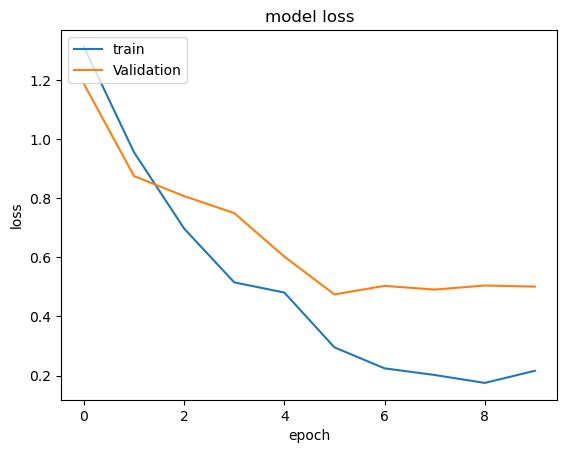

In [24]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

Evaluate the LSTM model

In [25]:
# evaluate model
test_loss, test_accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose=0)
print("Accuracy of the LSTM model", test_accuracy)
# Get the predictions for the test set
predictions = model.predict(testX)

Accuracy of the LSTM model 0.891414999961853
93/93 [==============================] - 3s 24ms/step


In [26]:
predictions

array([[8.82206671e-03, 1.10486624e-04, 8.21239155e-05, 1.05211344e-02,
        9.80458736e-01, 5.46115325e-06],
       [5.48556540e-03, 7.09713640e-05, 5.60233239e-05, 9.81407147e-03,
        9.84569609e-01, 3.74246952e-06],
       [4.93505877e-03, 6.21464496e-05, 5.08323319e-05, 9.54660960e-03,
        9.85402107e-01, 3.30558964e-06],
       ...,
       [1.30819269e-02, 9.67163920e-01, 1.95174031e-02, 3.34155229e-05,
        2.01988369e-04, 1.44067678e-06],
       [2.79779136e-02, 9.60790694e-01, 1.08185476e-02, 8.50024080e-05,
        3.18679260e-04, 9.14153952e-06],
       [6.35380158e-03, 9.87392485e-01, 6.16609957e-03, 2.72471170e-05,
        5.60170738e-05, 4.41127622e-06]], dtype=float32)

helper function to display results

In [30]:
def display_results(testy,predictions,classNames):
    y_test=np.argmax(testy, axis=1)
    y_scores=np.argmax(predictions, axis=1)
    classes = len(classNames)
    cm = confusion_matrix(y_test, y_scores)
    print("**** Confusion Matrix ****")
    print(cm)
    print("**** Classification Report ****")
    print(classification_report(y_test, y_scores, target_names=classNames))
    con = np.zeros((classes,classes))
    for x in range(classes):
        for y in range(classes):
            con[x,y] = cm[x,y] #/np.sum(cm[x,:])

    plt.figure(figsize=(10,8))
    df = sns.heatmap(con, annot=True, fmt='g', cmap='Blues',xticklabels= classNames , yticklabels= classNames)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

**** Confusion Matrix ****
[[466  22   8   0   0   0]
 [ 23 438   9   1   0   0]
 [  4  33 383   0   0   0]
 [  4   0   1 415  70   1]
 [  6   0   0  95 431   0]
 [  0  27  16   0   0 494]]
**** Classification Report ****
              precision    recall  f1-score   support

           1       0.93      0.94      0.93       496
           2       0.84      0.93      0.88       471
           3       0.92      0.91      0.92       420
           4       0.81      0.85      0.83       491
           5       0.86      0.81      0.83       532
           6       1.00      0.92      0.96       537

    accuracy                           0.89      2947
   macro avg       0.89      0.89      0.89      2947
weighted avg       0.89      0.89      0.89      2947



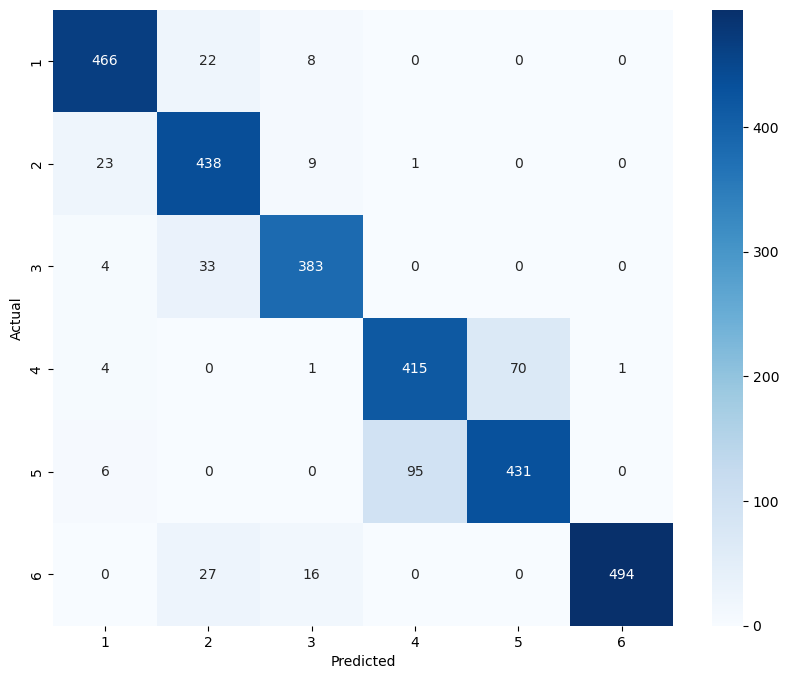

In [31]:
classNames=["1","2","3","4","5","6"]
display_results(testy,predictions,classNames)

### CNN model

Model design:

We will define the model as having two 1D CNN layers (each with 64 filters of kernel size 4), followed by a dropout layer to avoid overfiting for training set, then a pooling layer before flattening and connecting to the fully connected layer. At last we have the final softmax layer which represent the 6 classes similar to the LSTM model.

In [32]:
n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=4, activation='relu', input_shape=(n_timesteps,n_features)))
model.add(Conv1D(filters=64, kernel_size=4, activation='relu', input_shape=(n_timesteps,n_features)))
model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
plot_model(model, show_shapes=True, show_layer_names=True)

model.summary()

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 125, 64)           2368      
                                                                 
 conv1d_1 (Conv1D)           (None, 122, 64)           16448     
                                                                 
 dropout_6 (Dropout)         (None, 122, 64)           0         
                                                                 
 max_pooling1d (MaxPooling1D  (None, 61, 64)           0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 3904)              0         
                                     

Compile the model with [categorical_crossentropy](https://keras.io/api/losses/probabilistic_losses/#categoricalcrossentropy-class) loss function and [ADAM optimizer](https://keras.io/api/optimizers/).

In [33]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Train the model

In [34]:
# fit network
train_epochs = 20
history = model.fit(trainX, trainy, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_split=validation_split, shuffle=True)

Epoch 1/20
92/92 [==============================] - 3s 23ms/step - loss: 0.4716 - accuracy: 0.8130 - val_loss: 0.3879 - val_accuracy: 0.8973
Epoch 2/20
92/92 [==============================] - 2s 22ms/step - loss: 0.1445 - accuracy: 0.9434 - val_loss: 0.2963 - val_accuracy: 0.9109
Epoch 3/20
92/92 [==============================] - 2s 21ms/step - loss: 0.1165 - accuracy: 0.9524 - val_loss: 0.3357 - val_accuracy: 0.9150
Epoch 4/20
92/92 [==============================] - 2s 21ms/step - loss: 0.0943 - accuracy: 0.9575 - val_loss: 0.3590 - val_accuracy: 0.9062
Epoch 5/20
92/92 [==============================] - 2s 20ms/step - loss: 0.0863 - accuracy: 0.9617 - val_loss: 0.4155 - val_accuracy: 0.9116
Epoch 6/20
92/92 [==============================] - 2s 20ms/step - loss: 0.0890 - accuracy: 0.9577 - val_loss: 0.4382 - val_accuracy: 0.9075
Epoch 7/20
92/92 [==============================] - 2s 20ms/step - loss: 0.0852 - accuracy: 0.9623 - val_loss: 0.3866 - val_accuracy: 0.9123
Epoch 8/20
92

Visualize the training process (loss) w.r.t train set and the validation set

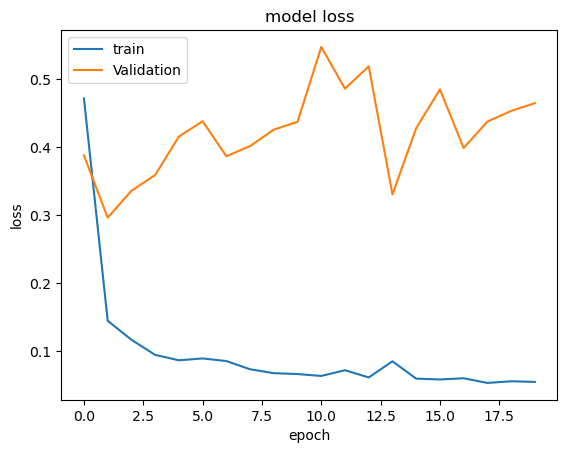

In [35]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

Evaluate the LSTM model

In [36]:
# evaluate model
test_loss, test_accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose=0)
print("Accuracy of the CNN model", test_accuracy)
predictions=model.predict(testX)

Accuracy of the CNN model 0.8978622555732727
93/93 [==============================] - 0s 3ms/step


**** Confusion Matrix ****
[[449  34  13   0   0   0]
 [  0 465   6   0   0   0]
 [  4  19 397   0   0   0]
 [  0   5   0 381 100   5]
 [  1   2   0  69 460   0]
 [  0  43   0   0   0 494]]
**** Classification Report ****
              precision    recall  f1-score   support

           1       0.99      0.91      0.95       496
           2       0.82      0.99      0.90       471
           3       0.95      0.95      0.95       420
           4       0.85      0.78      0.81       491
           5       0.82      0.86      0.84       532
           6       0.99      0.92      0.95       537

    accuracy                           0.90      2947
   macro avg       0.90      0.90      0.90      2947
weighted avg       0.90      0.90      0.90      2947



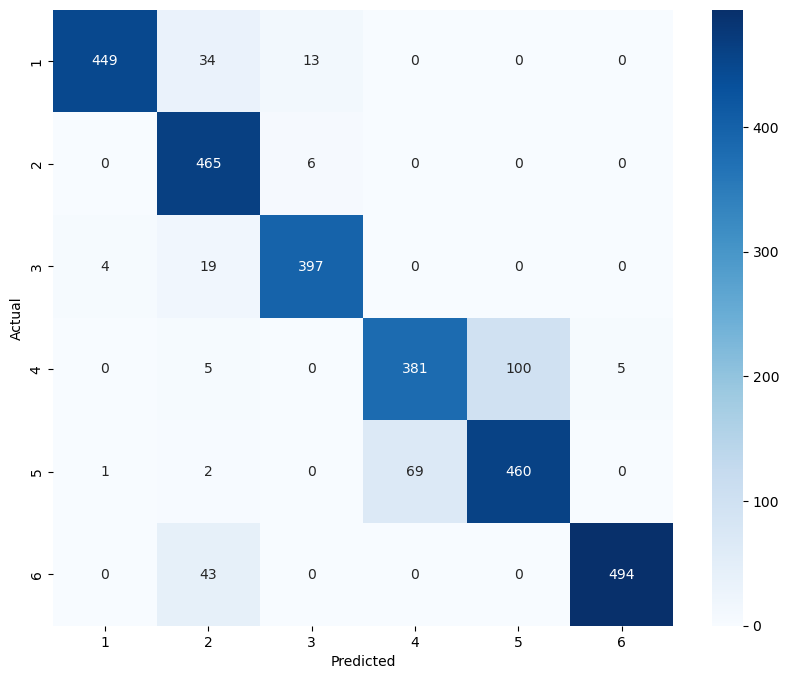

In [37]:
display_results(testy,predictions,classNames)

Predicting for a single sample

In [38]:
# we will select the first sample from the test set
sample = testX[0]
sample.shape

(128, 9)

In [39]:
# predict the results using the model, we need to input in the form of (numberOfSamples,featureLength,numberOfFeatures)
predictionForSample = model.predict(sample.reshape(1,sample.shape[0],sample.shape[1]))

1/1 [==============================] - 0s 20ms/step


In [40]:
# get the class of the sample
samplePredictedClass = np.argmax(predictionForSample, axis=1)
sampleActualClass = np.argmax(testy, axis=1)
print("Actual class: ",sampleActualClass[0])
print("Predicted class: ",samplePredictedClass[0])

Actual class:  4
Predicted class:  4
